# SVM Classification - Steel Surface Defect Detection

In [1]:
import kagglehub

path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/neu-surface-defect-database


## Import Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.feature import local_binary_pattern
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

import optuna
from sklearn.model_selection import cross_val_score
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Configuration & Parameters

In [3]:
TRAIN_PATH="/kaggle/input/neu-surface-defect-database/NEU-DET/train/images"
TEST_PATH = "/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images"
CHECKPOINT_DIR = "checkpoints"
MODEL_DIR = "models"

LBP_PARAMS = {
    "param1": {
        'radius': 1,
        'n_points': 8,
        'method': 'default'
    },
    'param2': {
        'radius': 1,
        'n_points': 8,
        'method': 'uniform'
    }
}

SIFT_PARAMS = {
    "param1": {
        'vocab_size': 100
    },
    'param2': {
        'vocab_size': 200
    }
}

class_names = sorted([f for f in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, f))])

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

## Data Loading Functions

In [4]:
def load_data(dataset_path):
    """Load dataset and return DataFrame"""
    data = []
    class_names = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))])
        
    for label in class_names:
        class_path = os.path.join(dataset_path, label)
        image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.bmp'))]
        
        for file_name in image_files:
            file_path = os.path.join(class_path, file_name)
            img = cv2.imread(file_path)
            data.append((file_path, label, img.shape))
            
    return pd.DataFrame(data, columns=['filepath', 'label', 'shape'])

In [5]:
df_train = load_data(TRAIN_PATH)
df_train.info()
df_train['label'].value_counts().sort_index()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1440 non-null   object
 1   label     1440 non-null   object
 2   shape     1440 non-null   object
dtypes: object(3)
memory usage: 33.9+ KB


,filepath,label,shape
0,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
1,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
2,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
3,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
4,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"


In [6]:
df_test = load_data(TEST_PATH)
df_test.info()
df_test['label'].value_counts().sort_index()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  360 non-null    object
 1   label     360 non-null    object
 2   shape     360 non-null    object
dtypes: object(3)
memory usage: 8.6+ KB


,filepath,label,shape
0,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
1,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
2,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
3,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"
4,/kaggle/input/neu-surface-defect-database/NEU-...,crazing,"(200, 200, 3)"


## Image Preprocessing

In [7]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def preprocess_image(image):
    """Preprocess image: grayscale, resize, CLAHE"""
    image = cv2.imread(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (200, 200), interpolation=cv2.INTER_AREA)
    gray = clahe.apply(gray)
    return gray

## LBP Feature Extraction

In [8]:
def extract_lbp(image, radius=1, n_points=8, method='default'):
    """Extract LBP features with specified parameters"""
    gray = preprocess_image(image)
    lbp = local_binary_pattern(gray, n_points, radius, method=method)
    
    if method == 'uniform':
        n_bins = n_points + 3
    else:
        n_bins = 2 ** n_points
    
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

## SIFT BoW Feature Extraction

In [9]:
class SiftBowExtractor:
    """SIFT Bag-of-Words feature extractor"""
    def __init__(self, vocab_size=100):
        self.vocab_size = vocab_size
        self.kmeans = MiniBatchKMeans(n_clusters=self.vocab_size, 
                                      batch_size=200, 
                                      random_state=42,
                                      n_init=10)
        self.vocabulary = None

    def _get_sift_descriptors(self, image):
        sift = cv2.SIFT_create()
        gray = preprocess_image(image)
        _, descriptors = sift.detectAndCompute(gray, None)
        return descriptors

    def fit(self, image_paths):
        """Build vocabulary from training images"""
        all_descriptors = []
        
        for img_path in tqdm(image_paths, desc="Building SIFT vocabulary"):
            descriptors = self._get_sift_descriptors(img_path)
            if descriptors is not None:
                all_descriptors.append(descriptors)
            
        all_descriptors = np.vstack(all_descriptors)
        self.kmeans.fit(all_descriptors)
        self.vocabulary = self.kmeans.cluster_centers_

    def transform(self, image_paths):
        """Transform images to BoW histograms"""
        final_features = []
        
        for img_path in tqdm(image_paths, desc="Extracting SIFT features"):
            descriptors = self._get_sift_descriptors(img_path)
            hist = np.zeros(self.vocab_size, dtype=float)
            
            if descriptors is not None:
                visual_words = self.kmeans.predict(descriptors)
                hist, _ = np.histogram(visual_words, bins=np.arange(self.vocab_size + 1))
                hist = hist.astype(float)
                hist /= (hist.sum() + 1e-6)
            
            final_features.append(hist)
            
        return np.array(final_features)

## Prepare Train/Test Data

In [10]:
X_train_paths = df_train['filepath'].tolist()
y_train = df_train['label'].tolist()

X_test_paths = df_test['filepath'].tolist()
y_test = df_test['label'].tolist()

## Extract LBP Features

In [11]:
lbp_train = {}
lbp_test = {}

for param_name, params in LBP_PARAMS.items():
    X_train_lbp = np.array([extract_lbp(p, **params) for p in tqdm(X_train_paths, desc=f"LBP {param_name} train")])
    X_test_lbp = np.array([extract_lbp(p, **params) for p in tqdm(X_test_paths, desc=f"LBP {param_name} test")])
    
    lbp_train[param_name] = {'features': X_train_lbp, 'params': params}
    lbp_test[param_name] = {'features': X_test_lbp, 'params': params}

LBP param2 test: 100%|██████████| 360/360 [00:03<00:00, 94.58it/s]


## Extract SIFT Features

In [12]:
sift_train = {}
sift_test = {}

for param_name, params in SIFT_PARAMS.items():
    extractor = SiftBowExtractor(**params)
    
    print(f"\nProcessing SIFT {param_name}...")
    extractor.fit(X_train_paths)
    
    X_train_sift = extractor.transform(X_train_paths)
    X_test_sift = extractor.transform(X_test_paths)
    
    sift_train[param_name] = {'features': X_train_sift, 'params': params, 'extractor': extractor}
    sift_test[param_name] = {'features': X_test_sift, 'params': params}
    
    extractor_path = f"{MODEL_DIR}/sift_extractor_svm_{param_name}.pkl"
    joblib.dump(extractor, extractor_path)


Processing SIFT param1...


Extracting SIFT features: 100%|██████████| 360/360 [00:09<00:00, 37.02it/s]



Processing SIFT param2...


Extracting SIFT features: 100%|██████████| 360/360 [00:10<00:00, 35.85it/s]


## Feature Scaling

In [13]:
def scale_features(train_dict, test_dict):
    """Scale features for all parameter sets"""
    scaled = {}
    
    for param_name in train_dict.keys():
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(train_dict[param_name]['features'])
        X_test_scaled = scaler.transform(test_dict[param_name]['features'])
        
        scaled[param_name] = {
            'train': X_train_scaled,
            'test': X_test_scaled,
            'scaler': scaler
        }
    
    return scaled

lbp_scaled = scale_features(lbp_train, lbp_test)
sift_scaled = scale_features(sift_train, sift_test)

## Optuna Optimization Setup

In [14]:
def objective_svm(trial, X_train, y_train):
    """Optuna objective function for SVM optimization"""
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    C = trial.suggest_float('C', 0.1, 1000, log=True)
    
    if kernel == 'rbf':
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, probability=True, random_state=42)
    else:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return cv_scores.mean()

def build_feature_sets():
    """Build all feature sets for optimization"""
    feature_sets = {}
    
    for param_name in LBP_PARAMS.keys():
        feat_name = f"LBP_{param_name}"
        feature_sets[feat_name] = (
            lbp_scaled[param_name]['train'], 
            lbp_scaled[param_name]['test'], 
            lbp_train[param_name]['params']
        )
    
    for param_name in SIFT_PARAMS.keys():
        feat_name = f"SIFT_{param_name}"
        feature_sets[feat_name] = (
            sift_scaled[param_name]['train'], 
            sift_scaled[param_name]['test'], 
            sift_train[param_name]['params']
        )
    
    return feature_sets

feature_sets = build_feature_sets()

## Train & Save Models

In [15]:
def train_and_save_model(feat_name, X_train, X_test, y_train, y_test, feat_params):
    """Train model with Optuna and save artifacts"""
    print(f"\n🔄 {feat_name} | Shape: {X_train.shape}")
    
    study = optuna.create_study(
        direction='maximize',
        study_name=f'SVM_{feat_name}',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(
        lambda trial: objective_svm(trial, X_train, y_train),
        n_trials=1000,
        show_progress_bar=True
    )
    
    best_model = SVC(**study.best_params, probability=True, random_state=42)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"✓ {feat_name}: CV={study.best_value:.4f} | Test={test_accuracy:.4f}")
    
    joblib.dump(study, f"{CHECKPOINT_DIR}/study_svm_{feat_name}.pkl")
    joblib.dump(best_model, f"{MODEL_DIR}/best_svm_{feat_name}.pkl")
    
    if feat_name.startswith("LBP"):
        param_name = feat_name.replace("LBP_", "")
        scaler = lbp_scaled[param_name]['scaler']
    else:
        param_name = feat_name.replace("SIFT_", "")
        scaler = sift_scaled[param_name]['scaler']
    
    joblib.dump(scaler, f"{MODEL_DIR}/scaler_svm_{feat_name}.pkl")
    
    metadata = {
        'feature_set': feat_name,
        'feature_params': feat_params,
        'model_type': 'SVM',
        'best_params': study.best_params,
        'cv_accuracy': float(study.best_value),
        'test_accuracy': float(test_accuracy),
        'n_trials': len(study.trials),
        'train_shape': X_train.shape,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open(f"{MODEL_DIR}/metadata_svm_{feat_name}.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    return {
        'study': study,
        'model': best_model,
        'cv_accuracy': study.best_value,
        'test_accuracy': test_accuracy,
        'best_params': study.best_params,
        'feature_params': feat_params
    }

optuna_results = {}
for feat_name, (X_train, X_test, feat_params) in feature_sets.items():
    optuna_results[feat_name] = train_and_save_model(
        feat_name, X_train, X_test, y_train, y_test, feat_params
    )

[I 2025-11-24 12:11:34,813] A new study created in memory with name: SVM_LBP_param1



🔄 LBP_param1 | Shape: (1440, 256)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 12:11:36,166] Trial 0 finished with value: 0.9534722222222222 and parameters: {'kernel': 'linear', 'C': 24.81040974867808}. Best is trial 0 with value: 0.9534722222222222.
[I 2025-11-24 12:11:37,348] Trial 1 finished with value: 0.9590277777777777 and parameters: {'kernel': 'rbf', 'C': 291.5443189153751, 'gamma': 'auto'}. Best is trial 1 with value: 0.9590277777777777.
[I 2025-11-24 12:11:37,658] Trial 2 finished with value: 0.9534722222222222 and parameters: {'kernel': 'linear', 'C': 0.70689749506246}. Best is trial 1 with value: 0.9590277777777777.
[I 2025-11-24 12:11:38,120] Trial 3 finished with value: 0.9638888888888889 and parameters: {'kernel': 'poly', 'C': 12.561043700013547, 'degree': 3, 'gamma': 'auto'}. Best is trial 3 with value: 0.9638888888888889.
[I 2025-11-24 12:11:38,675] Trial 4 finished with value: 0.9291666666666667 and parameters: {'kernel': 'poly', 'C': 6.6723671704642005, 'degree': 5, 'gamma': 'auto'}. Best is trial 3 with value: 0.9638888888888889.

[I 2025-11-24 12:19:21,803] A new study created in memory with name: SVM_LBP_param2



🔄 LBP_param2 | Shape: (1440, 11)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 12:19:21,968] Trial 0 finished with value: 0.9055555555555556 and parameters: {'kernel': 'linear', 'C': 24.81040974867808}. Best is trial 0 with value: 0.9055555555555556.
[I 2025-11-24 12:19:22,098] Trial 1 finished with value: 0.9284722222222221 and parameters: {'kernel': 'rbf', 'C': 291.5443189153751, 'gamma': 'auto'}. Best is trial 1 with value: 0.9284722222222221.
[I 2025-11-24 12:19:22,185] Trial 2 finished with value: 0.9090277777777779 and parameters: {'kernel': 'linear', 'C': 0.70689749506246}. Best is trial 1 with value: 0.9284722222222221.
[I 2025-11-24 12:19:22,280] Trial 3 finished with value: 0.8861111111111111 and parameters: {'kernel': 'poly', 'C': 12.561043700013547, 'degree': 3, 'gamma': 'auto'}. Best is trial 1 with value: 0.9284722222222221.
[I 2025-11-24 12:19:22,418] Trial 4 finished with value: 0.7631944444444446 and parameters: {'kernel': 'poly', 'C': 6.6723671704642005, 'degree': 5, 'gamma': 'auto'}. Best is trial 1 with value: 0.9284722222222221.

[I 2025-11-24 12:21:24,956] A new study created in memory with name: SVM_SIFT_param1



🔄 SIFT_param1 | Shape: (1440, 100)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 12:21:25,202] Trial 0 finished with value: 0.9701388888888888 and parameters: {'kernel': 'linear', 'C': 24.81040974867808}. Best is trial 0 with value: 0.9701388888888888.
[I 2025-11-24 12:21:25,612] Trial 1 finished with value: 0.9756944444444443 and parameters: {'kernel': 'rbf', 'C': 291.5443189153751, 'gamma': 'auto'}. Best is trial 1 with value: 0.9756944444444443.
[I 2025-11-24 12:21:25,850] Trial 2 finished with value: 0.9701388888888888 and parameters: {'kernel': 'linear', 'C': 0.70689749506246}. Best is trial 1 with value: 0.9756944444444443.
[I 2025-11-24 12:21:26,240] Trial 3 finished with value: 0.9152777777777779 and parameters: {'kernel': 'poly', 'C': 12.561043700013547, 'degree': 3, 'gamma': 'auto'}. Best is trial 1 with value: 0.9756944444444443.
[I 2025-11-24 12:21:26,832] Trial 4 finished with value: 0.7173611111111112 and parameters: {'kernel': 'poly', 'C': 6.6723671704642005, 'degree': 5, 'gamma': 'auto'}. Best is trial 1 with value: 0.9756944444444443.

[I 2025-11-24 12:28:24,865] A new study created in memory with name: SVM_SIFT_param2



🔄 SIFT_param2 | Shape: (1440, 200)


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2025-11-24 12:28:25,192] Trial 0 finished with value: 0.9756944444444443 and parameters: {'kernel': 'linear', 'C': 24.81040974867808}. Best is trial 0 with value: 0.9756944444444443.
[I 2025-11-24 12:28:25,884] Trial 1 finished with value: 0.9756944444444445 and parameters: {'kernel': 'rbf', 'C': 291.5443189153751, 'gamma': 'auto'}. Best is trial 1 with value: 0.9756944444444445.
[I 2025-11-24 12:28:26,205] Trial 2 finished with value: 0.9756944444444443 and parameters: {'kernel': 'linear', 'C': 0.70689749506246}. Best is trial 1 with value: 0.9756944444444445.
[I 2025-11-24 12:28:26,963] Trial 3 finished with value: 0.8965277777777779 and parameters: {'kernel': 'poly', 'C': 12.561043700013547, 'degree': 3, 'gamma': 'auto'}. Best is trial 1 with value: 0.9756944444444445.
[I 2025-11-24 12:28:27,910] Trial 4 finished with value: 0.6062500000000001 and parameters: {'kernel': 'poly', 'C': 6.6723671704642005, 'degree': 5, 'gamma': 'auto'}. Best is trial 1 with value: 0.9756944444444445.

## Classification Reports - All Models

In [16]:
for feat_name, result in optuna_results.items():
    model = result['model']
    
    if feat_name.startswith("LBP"):
        param_name = feat_name.replace("LBP_", "")
        X_test_feat = lbp_scaled[param_name]['test']
    else:
        param_name = feat_name.replace("SIFT_", "")
        X_test_feat = sift_scaled[param_name]['test']
    
    y_pred = model.predict(X_test_feat)
    
    print(f"Feature Set: {feat_name}")
    print(f"Feature Params: {result['feature_params']}")
    print(f"Best Model Params: {result['best_params']}")
    print(f"CV Accuracy: {result['cv_accuracy']:.4f} | Test Accuracy: {result['test_accuracy']:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names))

Feature Set: LBP_param1
Feature Params: {'radius': 1, 'n_points': 8, 'method': 'default'}
Best Model Params: {'kernel': 'poly', 'C': 4.8011083124526195, 'degree': 3, 'gamma': 'auto'}
CV Accuracy: 0.9660 | Test Accuracy: 0.8917
                 precision    recall  f1-score   support

        crazing       0.86      1.00      0.92        60
      inclusion       0.88      0.60      0.71        60
        patches       1.00      0.83      0.91        60
 pitted_surface       0.98      0.98      0.98        60
rolled-in_scale       1.00      1.00      1.00        60
      scratches       0.71      0.93      0.81        60

       accuracy                           0.89       360
      macro avg       0.90      0.89      0.89       360
   weighted avg       0.90      0.89      0.89       360

Feature Set: LBP_param2
Feature Params: {'radius': 1, 'n_points': 8, 'method': 'uniform'}
Best Model Params: {'kernel': 'rbf', 'C': 21.94365782109154, 'gamma': 'auto'}
CV Accuracy: 0.9306 | Test Accur


==================== Phân tích lỗi so sánh cho LBP (SVM) ====================


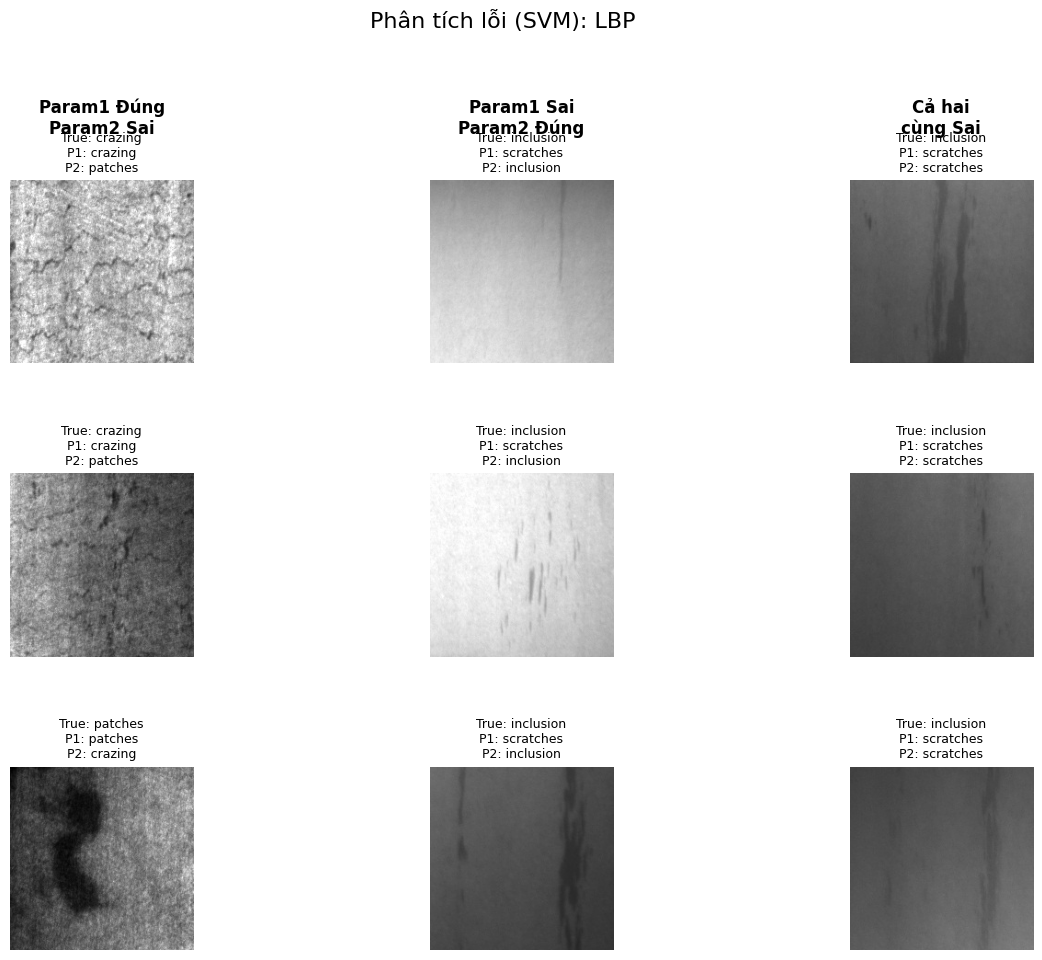


==================== Phân tích lỗi so sánh cho SIFT (SVM) ====================


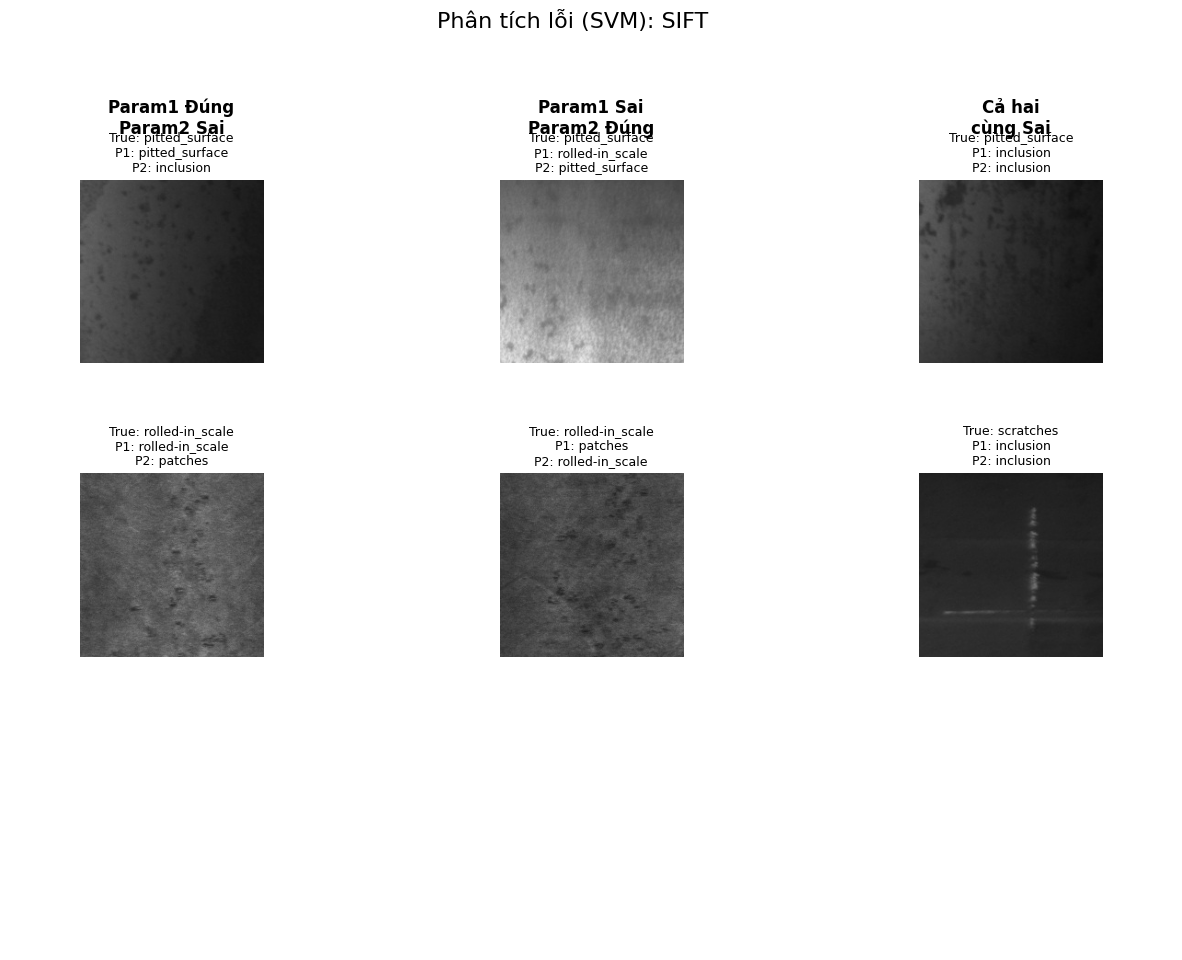

In [17]:
def visualize_comparative_errors_svm(feature_method, scaled_data_dict):
    """
    Hàm tìm và hiển thị 3 ảnh cho 3 kịch bản lỗi so sánh cho mô hình SVM:
    1. Param1 Đúng, Param2 Sai
    2. Param1 Sai, Param2 Đúng
    3. Cả hai đều Sai
    """
    print(f"\n{'='*20} Phân tích lỗi so sánh cho {feature_method} (SVM) {'='*20}")
    
    # Lấy tên khóa cho param1 và param2
    p1_name = f"{feature_method}_param1"
    p2_name = f"{feature_method}_param2"
    
    # Lấy mô hình SVM tốt nhất từ kết quả lưu trữ
    model_p1 = optuna_results[p1_name]['model']
    model_p2 = optuna_results[p2_name]['model']
    
    # Lấy dữ liệu test đã scale tương ứng
    X_test_p1 = scaled_data_dict['param1']['test']
    X_test_p2 = scaled_data_dict['param2']['test']
    
    # Thực hiện dự đoán
    pred_p1 = model_p1.predict(X_test_p1)
    pred_p2 = model_p2.predict(X_test_p2)
    
    # Phân loại chỉ số ảnh (indices) vào các nhóm
    case_p1_ok_p2_no = [] # P1 đúng, P2 sai
    case_p1_no_p2_ok = [] # P1 sai, P2 đúng
    case_both_no = []     # Cả hai đều sai
    
    for i in range(len(y_test)):
        true_label = y_test[i]
        p1_label = pred_p1[i]
        p2_label = pred_p2[i]
        
        if p1_label == true_label and p2_label != true_label:
            case_p1_ok_p2_no.append(i)
        elif p1_label != true_label and p2_label == true_label:
            case_p1_no_p2_ok.append(i)
        elif p1_label != true_label and p2_label != true_label:
            case_both_no.append(i)
            
    # Hàm hỗ trợ vẽ một cột ảnh (tối đa 3 ảnh)
    def plot_column(indices, col_idx, title_prefix):
        selected = indices[:3] # Chỉ lấy tối đa 3 ảnh đầu tiên
        for row_idx, img_idx in enumerate(selected):
            ax = axes[row_idx, col_idx]
            
            # Load và xử lý ảnh để hiển thị
            img_path = X_test_paths[img_idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            ax.imshow(img)
            ax.axis('off')
            
            # Tiêu đề cho từng ảnh con
            true_lbl = y_test[img_idx]
            p1_lbl = pred_p1[img_idx]
            p2_lbl = pred_p2[img_idx]
            
            # Đặt màu chữ để dễ phân biệt (Xanh: Đúng, Đỏ: Sai)
            color_p1 = 'green' if p1_lbl == true_lbl else 'red'
            color_p2 = 'green' if p2_lbl == true_lbl else 'red'
            
            ax.set_title(f"True: {true_lbl}\nP1: {p1_lbl}\nP2: {p2_lbl}", fontsize=9)
        
        # Đặt tiêu đề cột ở hàng đầu tiên
        if len(indices) > 0 or len(selected) == 0: # Luôn hiện tiêu đề cột
             axes[0, col_idx].text(0.5, 1.25, title_prefix, 
                                size=12, ha="center", transform=axes[0, col_idx].transAxes, weight='bold')

    # Tạo lưới plot 3x3
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.6, wspace=0.3)
    
    # Xử lý trường hợp lưới trống (ẩn các trục không dùng)
    for ax_row in axes:
        for ax in ax_row:
            ax.axis('off')

    # Vẽ Cột 1: Param1 Đúng, Param2 Sai
    if case_p1_ok_p2_no:
        plot_column(case_p1_ok_p2_no, 0, "Param1 Đúng\nParam2 Sai")
    else:
        axes[0, 0].set_title("Không có mẫu nào", fontsize=10)
        axes[0, 0].text(0.5, 1.25, "Param1 Đúng\nParam2 Sai", size=12, ha="center", transform=axes[0, 0].transAxes, weight='bold')

    # Vẽ Cột 2: Param1 Sai, Param2 Đúng
    if case_p1_no_p2_ok:
        plot_column(case_p1_no_p2_ok, 1, "Param1 Sai\nParam2 Đúng")
    else:
        axes[0, 1].set_title("Không có mẫu nào", fontsize=10)
        axes[0, 1].text(0.5, 1.25, "Param1 Sai\nParam2 Đúng", size=12, ha="center", transform=axes[0, 1].transAxes, weight='bold')

    # Vẽ Cột 3: Cả hai cùng Sai
    if case_both_no:
        plot_column(case_both_no, 2, "Cả hai\ncùng Sai")
    else:
        axes[0, 2].set_title("Không có mẫu nào", fontsize=10)
        axes[0, 2].text(0.5, 1.25, "Cả hai\ncùng Sai", size=12, ha="center", transform=axes[0, 2].transAxes, weight='bold')

    plt.suptitle(f"Phân tích lỗi (SVM): {feature_method}", fontsize=16, y=1.05)
    plt.show()

# --- Thực thi ---

# 1. Phân tích lỗi cho LBP với SVM
visualize_comparative_errors_svm('LBP', lbp_scaled)

# 2. Phân tích lỗi cho SIFT với SVM
visualize_comparative_errors_svm('SIFT', sift_scaled)